<a href="https://colab.research.google.com/github/rgmantovani/advancedML/blob/master/codes/aula_08_ds_flow/DAES_CNN_exemplo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso de Ensembles

Disciplina: Métodos e Modelos Avançados em Ciência de Dados

Especialização em Ciência de Dados - Universidade Tecnologica Federal do Paraná

**Aula 07:** Fluxo de DS para solução de problemas reais

**Exemplo 01:** Executando CNN pré-treinada por um Denoising Autoencoder (DAE)

by: Rafael G. Mantovani

---

Para a execução ser mais rápida, mudar as opções de execução no colab para uso de GPUs.

*COLAB: "Go to Runtime > Change runtime and select a GPU hardware accelerator."*

---
## Descrição geral do exemplo

**Objetivo**: aplicar uma Rede Neural Convolucional (*Convolutional Neural Network* - CNN) para resolver um problema de classificação de imagens. Porém, iremos usar um *Denoising Autoencoder* (DAE) para inicializar os pesos da CNN, via pré-treino. Por fim, comparamos o desempenho da mesma arquitetura de CNN com e sem pré-treino via DAE.

O exemplo envolve os seguintes passos de abstração:

1. Definir todo o ambiente de experimentação do script com os imports necessários;

2. Obter o conjunto de dados de imagem para o exemplo. 
Aqui vamos usar o CIFAR-10, que possui um conjunto de treinamento com 50 mil imagens, e um conjunto de teste com 10 mil exemplos. Todos os exemplos são imagens coloridas, descritas em RBG, ou seja, uma imagem é uma matriz tridimensional 32 x 32 x 3 (largura x altura x canais de cores). O CIFAR-10 possui 10 classes distintas.

3. Treinar um *Denoising Autoencoder* (DAE) para reconstruir os padrões de entrada (images) mesmo com a presença de ruídos que iremos inserir artificialmente. O treino do DAE será feito com todo do conjunto de treinamento (50 mil exemplos).

4. Definir uma CNN (CNN1) com a mesma estrutura do encoder do DAE: parte responsável por obter as representações latentes.
Iremos obter os pesos do DAE já treinado, e atribuir às camadas da CNN. Em sequência, adicionaremos algumas camadas densas para que consigamos ter o resultado da classificação.

5. Paralelamente, criamos uma segunda CNN (CNN2), com a mesma arquitetura da CNN1, mas com os pesos iniciados aleatoriamente (*default* no keras).

6. Iremos selecionar, aleatoriamente 5 mil exemplos do conjunto de treinamento. Não iremos treinar a CNN com o conjunto de treinamento completo, mas sim com esse sub-conjunto selecionado (sub_train). A amostragem pode ser feitas pelo método simples, mas optei por realizar uma amostragem estratificada, ou seja, o sub-conjunto amostrando contém a mesma quantidade de exemplos para uma das dez classes do dataset original.

7. Treinaremos as duas CNNs usando o subset definido no passo anterior. A configuração de treinamento dos dois modelos é a mesma (idêntica): 10 épocas, otimizador Adam, e avaliação via acurácia.

8. Realizamos as predições dos modelos já induzidos, mas agora no conjunto de teste (10 mil imagens). 

9. Avaliamos o desempenho dos dois algoritmos, olhando as predições, *performances* (acurácia) no conjunto de teste, e matrizes de confusão de ambos os modelos induzidos.


Detalhes mais específicos serão incluídos nos correspondentes trechos de código.


In [1]:
#import de todas as bibliotecas necessárias para o script funcionar

import tensorflow as tf             # tensor flow
from tensorflow import keras        # keras e DL
import numpy as np                  # manipulação de numeros na notação científica
import matplotlib as mpl            # plots/graficos
import matplotlib.pyplot as plt     # plots/graficos
import random                       # numeros aleatorios
import seaborn as sn                # heatmaps
import pandas as pd                 # data frames

from sklearn.metrics import confusion_matrix               # computar matriz de confusão
from sklearn.model_selection import StratifiedShuffleSplit # amostragem estratificada

In [2]:
# seed para reprodução dos experimentos
myseed = 42

np.random.seed(myseed)
tf.random.set_seed(myseed)
random.seed(myseed)

In [3]:
# Obter o dataset CIFAR-10 via keras, e dividir as amostras em conjuntos
# distintos de treino e teste
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()

# aqui, dividimos todos os pixels por 255 para normalizar os valores entre [0, 1]
X_train = X_train / 255
X_test  = X_test / 255

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
# Para facilitar lá na frente o reaproveitamento dos pesos do DAE, 
# vamos criar externamente imagems com ruídos aletórios
# Assim, X_train_noisy é um conjunto com 50 mil imagens com rúidos

n_images = len(X_train)
X_train_noisy = X_train + np.random.randn(n_images, 32, 32, 3) * 0.1

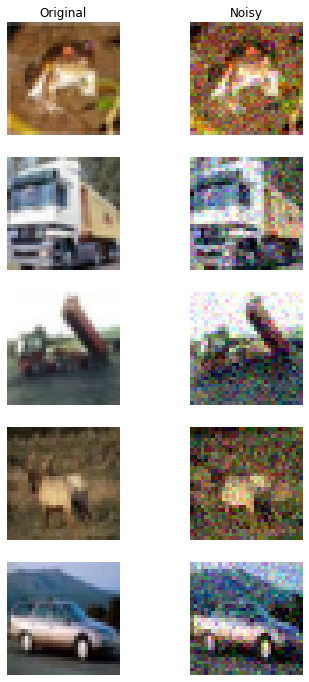

In [57]:
# Podemos então ver como são essas imagens que geramos
# Para isso, vamos comparar com as correspondentes imagens originais
# para fins didáticos, visualizamos apenas 5 imagens, 
# mas poderia ser qualquer número aqui

n_images = 5

#  Coluna da esquerda - imagens originais
#  Coluna da direita  - imagens ruidosas
 
plt.figure(figsize=(6, 12))
for index in range(n_images):
    plt.subplot(n_images, 2, index * 2 + 1)
    plt.imshow(X_train[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 2, index * 2 + 2)
    plt.imshow(np.clip(X_train_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
plt.show()

In [5]:
# Definir um encoder para DAE
denoising_encoder = keras.models.Sequential(
    name = "dae_encoder",
    layers=[ 
      keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[32,32,3]),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation="relu"),
])

# mostrar a arquitetura (camadas)
denoising_encoder.summary()

Model: "dae_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
Total params: 4,195,712
Trainable params: 4,195,712
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Definir um decoder para DAE 
denoising_decoder = keras.models.Sequential(
    name = "dae_decodder",
    layers=[keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
      keras.layers.Reshape([16, 16, 32]),
      keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])
# mostrar a arquitetura (camadas)
denoising_decoder.summary()

Model: "dae_decodder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              4202496   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 3)         867       
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Cria o DAE = encoder + decoder
denoising_ae = keras.models.Sequential(
    name = "dae",
    layers = [denoising_encoder, denoising_decoder])

# mostrar a arquitetura do DAE (camadas)
denoising_ae.summary()

Model: "dae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dae_encoder (Sequential)     (None, 512)               4195712   
_________________________________________________________________
dae_decodder (Sequential)    (None, 32, 32, 3)         4203363   
Total params: 8,399,075
Trainable params: 8,399,075
Non-trainable params: 0
_________________________________________________________________


In [8]:
# definir o numero de epocas usados para treinar todos os modelos 
#  tanto o DAE, como as CNNs
my_epochs = 10

In [9]:
# treinaremos o DAE usando ADAM, e MSE
denoising_ae.compile(loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(),
    metrics=["mse"])

# a entrada X, são as imagens com ruidos, e os 'labels' são as reconstruções
# que desejamos, que são as imagens originais (sem ruídos)
history = denoising_ae.fit(
    x=X_train_noisy, 
    y=X_train, 
    epochs=my_epochs, 
    validation_data=(X_test, X_test)
)

Epoch 1/10
1563/1563 [==============================] - 51s 11ms/step - loss: 0.6128 - mse: 0.0271 - val_loss: 0.5939 - val_mse: 0.0177
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5752 - mse: 0.0107 - val_loss: 0.5745 - val_mse: 0.0102
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5677 - mse: 0.0083 - val_loss: 0.5715 - val_mse: 0.0090
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5664 - mse: 0.0073 - val_loss: 0.5716 - val_mse: 0.0091
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5646 - mse: 0.0068 - val_loss: 0.5682 - val_mse: 0.0077
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5636 - mse: 0.0065 - val_loss: 0.5677 - val_mse: 0.0075
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5624 - mse: 0.0062 - val_loss: 0.5662 - val_mse: 0.0070
Epoch 8/10
1563/1563 [==========================

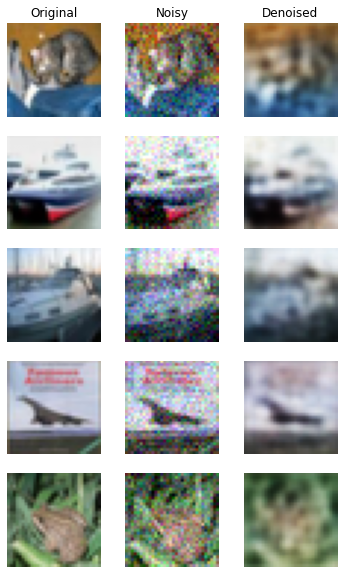

In [10]:
# Vamos visualizar nossas reconstruções
# coluna da esquerda - imagens originais
# coluna central     - imagens ruidosas
# cluna da direita   - imagens reconstruídas

n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

---
## Definir CNN 1 - Inicializar com pré-treino

In [11]:
# Primeiro vamos acessar os pesos do encoder
dae_ws = denoising_encoder.get_weights()

# listar o formato dos pesos de cada camada
print(len(dae_ws)) # 4 camadas
for i in range(len(dae_ws)):
  print(dae_ws[i].shape)

4
(3, 3, 3, 32)
(32,)
(8192, 512)
(512,)


In [13]:
# Criar uma CNN (CNN1) com a mesma arquitetura do encoder do DAE
cnn1 = keras.models.Sequential(
    name = "cnn_pretrained",
    layers = [
      keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation="relu")
])

# mostrar a arquitetura (camada por camada)
cnn1.summary()

Model: "cnn_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
Total params: 4,195,712
Trainable params: 4,195,712
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Inicializando os pesos da CNN1 com os valores já treinados 
# anteriormente pleo DAE
cnn1.set_weights(dae_ws)

In [15]:
# Adicionando mais uma camada densa, com 10 neurônios, e
# função sigmoidal, para retornar as classes
cnn1.add(tf.keras.layers.Dense(10, activation='sigmoid'))

# mostrando o modelo para classificação
cnn1.summary()

Model: "cnn_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 4,200,842
Trainable params: 4,200,842
Non-trainable params: 0
_________________________________________________________________


---
## Definir CNN 2 - Inicializar sem pré-treino


In [16]:
# criar CNN2 com a mesma arquitetura da CNN1, e pesos inicializados
# aleatoriamente
cnn2 = keras.models.Sequential(
    name = "cnn_not_pretrained",
    layers = [keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation="relu"),
      keras.layers.Dense(10, activation="sigmoid")
])

# mostrar o modelo (camada por camada)
cnn2.summary()

Model: "cnn_not_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 4,200,842
Trainable params: 4,200,842
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Aqui nós vamos selecionar apenas 5 mil dos 50 mil exemplos do 
# conjunto de treinamento para treinar as CNNs

# A estratégia é realizar uma amostragem estratificada 
# (mesma quantidade de exemplo por classe)
sss = StratifiedShuffleSplit(n_splits=10, random_state=myseed)
smp = []
for train_index, test_index in sss.split(X_train, y_train.ravel()):
    # print("TRAIN:", train_index, "TEST:", test_index)
    smp.append(test_index)

y_train_subsample_stratified = y_train[smp[0]]
X_train_subsample_stratified = X_train[smp[0]]

# Mostrando a quantidade de exemplos selecionados (X_train, y_train)
print(X_train_subsample_stratified.shape)
print(y_train_subsample_stratified.shape)

# distribuição de classes na amostra
print('Class distribution - {}'.format(np.bincount(y_train_subsample_stratified.ravel())))

(5000, 32, 32, 3)
(5000, 1)
Class distribution - [500 500 500 500 500 500 500 500 500 500]


In [145]:
# Aqui é um segunda opcõa, ao inves de realizar amostragem estratificada
# é feita uma amostragem simples

# ids = random.sample(population=range(len(X_train)), k=5000)

# X_train_subsample = X_train[ids]
# y_train_subsample = y_train[ids]

# print(X_train_subsample.shape)
# print(y_train_subsample.shape)
# print('Class distribution - {}'.format(np.bincount(y_train_subsample.ravel())))

---
## Treinar ambas as CNNs

In [20]:
# treinar a CNN1 (com pré-treino)
cnn1.compile(loss="sparse_categorical_crossentropy", 
                     optimizer=keras.optimizers.Nadam(),
                     metrics=["accuracy"])

cnn1_history = cnn1.fit(
    x = X_train_subsample_stratified, 
    y = y_train_subsample_stratified, 
    epochs = my_epochs,
    # validation_split = 0.3
)

Epoch 1/10
157/157 [==============================] - 2s 6ms/step - loss: 2.0330 - accuracy: 0.2756
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 1.3930 - accuracy: 0.5131
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 1.1037 - accuracy: 0.6209
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 0.9627 - accuracy: 0.6772
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.7760 - accuracy: 0.7408
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 0.6104 - accuracy: 0.8112
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 0.4595 - accuracy: 0.8642
Epoch 8/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3487 - accuracy: 0.9130
Epoch 9/10
157/157 [==============================] - 1s 6ms/step - loss: 0.2571 - accuracy: 0.9368
Epoch 10/10
157/157 [==============================] - 1s 6ms/step - loss: 0.2100 - accuracy: 0.9537

In [21]:
# Treinar a CNN2, sem pre-treino
cnn2.compile(loss="sparse_categorical_crossentropy", 
                     optimizer=keras.optimizers.Nadam(),
                     metrics=["accuracy"])

cnn2_history = cnn2.fit(
    x = X_train_subsample_stratified, 
    y = y_train_subsample_stratified, 
    epochs = my_epochs,
    # validation_split = 0.3
)

Epoch 1/10
157/157 [==============================] - 2s 6ms/step - loss: 2.2409 - accuracy: 0.2287
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 1.5581 - accuracy: 0.4443
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 1.2982 - accuracy: 0.5396
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 1.1773 - accuracy: 0.5942
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 1.0052 - accuracy: 0.6489
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 0.8534 - accuracy: 0.7181
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 0.6904 - accuracy: 0.7686
Epoch 8/10
157/157 [==============================] - 1s 6ms/step - loss: 0.5730 - accuracy: 0.8299
Epoch 9/10
157/157 [==============================] - 1s 6ms/step - loss: 0.4746 - accuracy: 0.8597
Epoch 10/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3926 - accuracy: 0.8873

In [22]:
# Obter as predicoes da CNN 1
prediction_cnn1 = np.argmax(cnn1.predict(X_test), axis=-1)
print(prediction_cnn1)

# Visualizar as predicoes no formato de uma matriz de confusão
print('\n*Confusion Matrix')
mat_cnn1 = confusion_matrix(y_test, prediction_cnn1)
print(mat_cnn1)

[3 1 8 ... 5 1 4]

*Confusion Matrix
[[483  24 294  27   8  11  21  33  67  32]
 [ 42 648  48  25   2   5  36  24  29 141]
 [ 37   9 647  50  37  50 100  60   4   6]
 [ 13  11 231 349  36 108 127  93  11  21]
 [ 17   3 346  87 215  28 159 132   6   7]
 [  8   8 250 202  21 289  87 114  12   9]
 [  5  11 145  67  20  22 678  35   8   9]
 [ 17   3 147  69  26  42  42 632   0  22]
 [124  70 130  25   4   9  24  10 557  47]
 [ 57 165  75  20   4   7  46  58  39 529]]


In [23]:
# Obter as predicoes da CNN 2
prediction_cnn2 = np.argmax(cnn2.predict(X_test), axis=-1)
print(prediction_cnn2)

# Visualizar as predicoes no formato de uma matriz de confusão
print('\n*Confusion Matrix')
mat_cnn2 = confusion_matrix(y_test, prediction_cnn2)
print(mat_cnn2)

[3 1 8 ... 5 1 4]

*Confusion Matrix
[[367  30 346  32  10  13  30  27  91  54]
 [ 23 593  55  34   3   8  31  22  48 183]
 [ 21   9 618  54  48  66  95  58  16  15]
 [  5  10 192 376  40 139 119  79  12  28]
 [  8   2 343  85 232  50 135 131   5   9]
 [  4   2 217 195  24 369  58 105  15  11]
 [  0   3 145  82  25  22 672  37   4  10]
 [  7   4 129  69  28  67  30 639   2  25]
 [ 67  60 117  24   1  12  15  13 613  78]
 [ 34 118  54  28   3  17  43  53  33 617]]


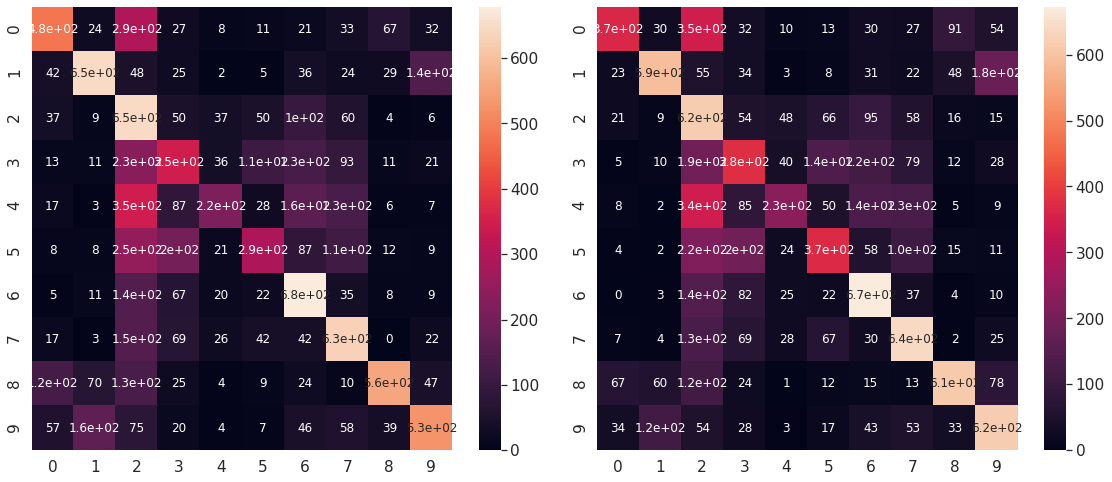

In [28]:
# Plotar as matrizes de confusão 
# ideal é ter célular mais claras na diagonal principal

df_cnn1 = pd.DataFrame(mat_cnn1, range(10), range(10))
df_cnn2 = pd.DataFrame(mat_cnn2, range(10), range(10))

plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cnn1, annot=True, annot_kws={"size": 12}) # font size

plt.subplot(1, 2, 2)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cnn2, annot=True, annot_kws={"size": 12}) # font size

plt.tight_layout() 
plt.show()

In [25]:
# Avaliar os modelos no conjunto de treinamento
# e ver o desempenhode ambas as cnns
score_cnn1 = cnn1.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {round(score_cnn1[0],5)} / Test accuracy: {round(score_cnn1[1],5)}')

score_cnn2 = cnn2.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {round(score_cnn2[0],5)} / Test accuracy: {round(score_cnn2[1],5)}')

Test loss: 1.93925 / Test accuracy: 0.5028
Test loss: 1.62642 / Test accuracy: 0.5095


---

**Algumas perguntas:**
* Qual a melhor estratégia?
* Como melhorar o pré-treino?
* O que aconteceria se replicassemos o experimento em outro dataset?


Bons estudos :)